# Exercise 4: Wind-generated set-up and circulations in a homogeneous lake

Wind over a lake can generate a water level set-up and drive both horizontal and vertical circulations. In this exercise we study set-up and circulations in a lake with uniform density. We investigate the effects of depth variation, and consider consequences of modelling this situation in either 2DH or 3D.

The lake covers an area of 10 km by 10 km and is 5 m deep. The westerly wind blows steadily with $U_{10}$ = 15.0 m/s.

## 4.1)  Wind over lake with uniform depth (2DH)

a)	Estimate the wind generated water level set-up at the east side of the lake. To do this, derive an expression for the water level set-up $\zeta$ from the depth-averaged momentum balance in $x$-direction (west-east), considering that a balance will develop between wind stress and pressure gradient. 

\begin{equation} 
    \rho_w \frac{\partial U}{\partial t} + \rho_w U \frac{\partial U}{\partial x} + \rho_w V \frac{\partial U}{\partial y} =
    -\rho_w g \frac{\partial \zeta}{\partial x} + \frac{\tau_{wind,x}}{h+\zeta} - \frac{\tau_{b,x}}{h+\zeta}
\end{equation}

Note that the wind shear stress $\tau_{wind,x}$ equals:

$ \tau_{wind,x} = \rho_{air} C_D | U_{10} | U_{10}$

with 

$\rho_w$ = 1000 kg/m$^3$

$\rho_{air}$ = 1.2 kg/m$^3$

$C_D$ = 2 x 10$^{-3}$

$h$ = 3 m

b)	Set the parameters to simulate this situation (using a 2DH-model) and compare the estimated and computed water level set-up.

c)	Investigate the sensitivity of the set-up for changes in wind speed and depth. For what type of lakes is the water level set-up the greatest: deep or shallow lakes? 

In [1]:
# Imports
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import time
import os
# Something very fishy happening if I don't define a plot first.
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
plt.ioff()
_ = plt.figure()
plt.ion()

In [2]:
# Toggle button for hiding the raw code
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
.widget-box {
  overflow: visible;
}
</style>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
# Get dflowfm software and model schematization
basepath = (os.path.abspath(os.path.join(os.getcwd(),"..","..")))
engine = os.path.join(basepath, r"dflowfm_exe\x64\share\bin\dflowfm")
mdufile = os.path.join(basepath, r"4_Lakes\Models\w1.mdu") 

In [4]:
# for i in range(wrapper.get_var_count()):
#     print(wrapper.get_var_name(i), wrapper.get_var_shape(wrapper.get_var_name(i)))

In [5]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile);
wrapper.initialize();
# wrapper.update()

In [23]:
maxsteps = 300
parameters = [
    {
        "parameter": "wx",
        "description": "Wind velocity $[m/s]$",
        "default": 15
    },    {
        "parameter": "frcu",
        "description": r"Roughness Chézy $[\sqrt{m}/s]$",
        "default": str(wrapper.get_var("frcu")[0])
    },   {
        "parameter": "zk",
        "description": "Depth of bed level $[m]$  -",
        "default": str(abs(wrapper.get_var("zk")[-1]))
    }
]

In [20]:
# Create widgets
style = {'description_width': 'initial'}

run = widgets.Button(
    description='Run model',
    button_style='',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)


nsteps = widgets.BoundedIntText(
    description="Number of timesteps",
    value=500,
    min=0,
    max=maxsteps,
    style=style,
    layout=Layout(width='15vw')
)

slider = widgets.IntSlider(  
    min=0,
    max=1,
    value=0, 
    continuous_update=False
)

widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

# parameters = ["zbndz", "zbndq", "frcu"]
# p_descrip = ["Boundary Water level", "Boundary Discharge", "Roughness Chézy"]

items=[]
for p in parameters: 
    items.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))

In [8]:
  
# Model specific function  #read all the model info
xz = wrapper.get_var('xz')[:]
yz = wrapper.get_var('yz')[:]
indy = np.argsort(yz)[::-1]
newx = xz[indy]

randind = np.random.choice(len(xz), int(len(xz)/5), replace=False)

lX = len(np.unique(xz))
lY = len(np.unique(yz))
newx = newx.reshape((lY, lX))
indx = np.argsort(newx, axis=1)


def grid2matrix(arr):
    new_arr = arr.copy()
    new_arr = new_arr[indy]
    new_arr = new_arr.reshape((lY, lX))

    c = np.zeros_like((new_arr))

    for i, x in enumerate(new_arr):
        c[i, :] = new_arr[i, indx[i]]
    return c

#     Automate parameter and grid sizes
def update_data():
    ucx = wrapper.get_var('ucx')[:]
    ucy = wrapper.get_var('ucy')[:]
    s1 = wrapper.get_var('s1')[:]
    
    data.append(dict({
        "time": wrapper.get_current_time(),
        "ucx": ucx.copy(), 
        "ucy": ucy.copy(), 
        "top_ucx": grid2matrix(ucx),
        "top_s1": grid2matrix(s1)
    }))
    slider.max = len(data)
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [21]:
# Standard functions for button widgets #DONT CHANGE!
dostop = False
def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(wrapper.get_time_step())
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop(n):
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()): #check if your last ts is the same ts as model
            stop_model()
            break
        if dostop == True: 
            stop_model()
            break
    stop_model()

def run_model(change=None): 
#     When the run/stop model button is pressed either start the model loop or stop it
    run.disabled = True
    update.disabled = True
    restart.disabled = True
    settings.disabled = True
    nsteps.disabled = True
    for i in items:
        i.disabled = True
    start_loop(int(nsteps.value))
#         thread = threading.Thread(target=start_loop)
#         thread.start()

def stop_model(change=None):
    update.disabled = False
    restart.disabled = False
    run.disabled = False
    nsteps.disabled = False
    for i in items:
        i.disabled = False
    dostop = True

def change_param(v): #dont touch
    try:
        v = v.owner
    except AttributeError: 
        v = v
    if v.value == "":
        return
    try:
        float(v.value)
        old_par = wrapper.get_var(v.placeholder)
        new_par = np.ones_like(old_par) * float(v.value)
        if v.placeholder == 'zk': 
            print(v.placeholder, new_par[-1])
            new_par *= -1
            wrapper.set_var_slice('zk', [1], [len(new_par)], new_par) 
            settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
            return
        wrapper.set_var(v.placeholder, new_par)
        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
    except ValueError:
        v.value = str(next((x['default'] for x in parameters if x['parameter'] == v.placeholder), None))
        settings.value = "Not a correct input for {}".format(v.description)

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(parameters[i]['default'])
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    slider.value = 0
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

zk 4.0


<IPython.core.display.Javascript object>


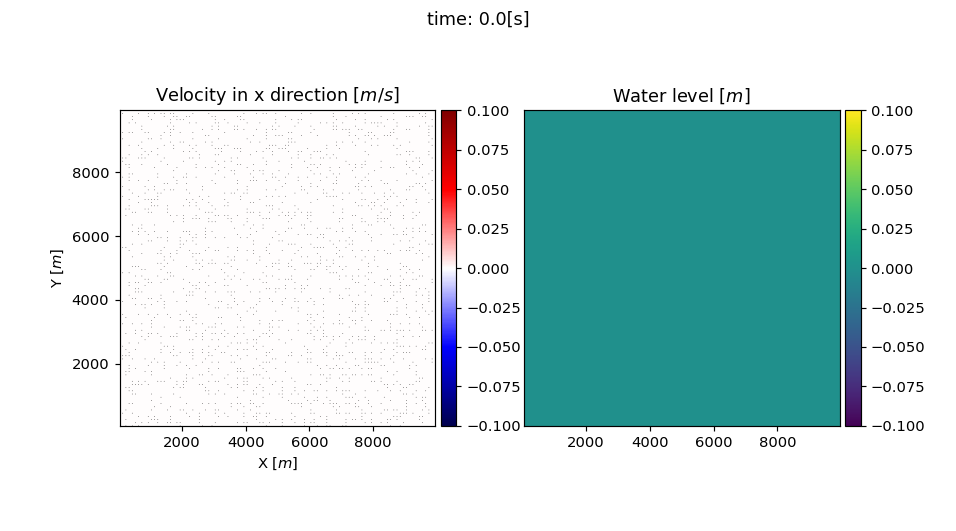

In [24]:
# set plot size
plt.rcParams["figure.figsize"] = (9, 5) # (w, h)

# link functions to widgets
run.on_click(run_model)
update.on_click(update_model)
restart.on_click(restart_model)

def set_plot(change):
    minU = data[-1]["top_ucx"].min()
    maxU = data[-1]["top_ucx"].max()
    minS = data[-1]["top_s1"].min()
    maxS = data[-1]["top_s1"].max()
    
#     print(maxV, minV)
    ux_top.set_clim(vmin= -round(1.2 *  max(abs(minU), abs(maxU)), 2), vmax=round(1.2 *  max(abs(minU), abs(maxU)), 2))
    s1_top.set_clim(vmin= -round(1.2 *  max(abs(minS), abs(maxS)), 2), vmax=round(1.2 *  max(abs(minS), abs(maxS)), 2))

    t = change['new']
    if (t < len(data)):
        ux_top.set_data(data[t]["top_ucx"])
        s1_top.set_data(data[t]["top_s1"])
        t1.set_text("time: " + str(data[t]["time"]) + "[s]")
        quiver.set_UVC(data[t]["ucx"][randind], data[t]["ucy"][randind])
        fig.canvas.draw()
        
slider.observe(set_plot, 'value')

controls = HBox([run, update, restart])
params = VBox(items)

for i in items: 
    change_param(i)
    i.observe(change_param, names='value')

display(VBox([settings, HBox([nsteps, controls]), HBox([params])]))
fig,(ax0, ax1) = plt.subplots(1, 2)
display(player)

t1 = fig.suptitle("time: " + str(data[0]["time"]) + "[s]")

ux_top = ax0.imshow(data[0]["top_ucx"], extent=[xz.min(), xz.max(), yz.min(), yz.max()], cmap="seismic")
ax0.set_xlabel("X $[m]$")
ax0.set_ylabel("Y $[m]$")
# quiver = ax0.quiver(xz[randind], yz[randind], data[0]["ucx"][randind], data[0]["ucy"][randind], angles='xy', scale_units='xy', scale=0.0000001)
quiver = ax0.quiver(xz[randind], yz[randind], data[0]["ucx"][randind], data[0]["ucy"][randind], angles='xy', scale_units='xy', scale=0.0001)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(ux_top, cax=cax0);
ax0.set_title('Velocity in x direction $[m/s]$')


s1_top = ax1.imshow(data[0]["top_s1"], extent=[xz.min(), xz.max(), yz.min(), yz.max()])
ax1.set_title('Water level $[m]$')
ax1.get_yaxis().set_visible(False)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cbar1 = plt.colorbar(s1_top, cax=cax1);
plt.draw()


In [18]:
wrapper.get_var('bl')

array([-2., -2., -2., ..., -2., -2., -2.])